# Demonstration of Noise

In [24]:
%load_ext autoreload
%autoreload 2  

import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import minkowski, cosine
from IPython.display import display
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt
import seaborn as sns

print("PyTorch Version:", torch.__version__)
print("MPS Available:", torch.backends.mps.is_available())
print("MPS Built:", torch.backends.mps.is_built())

import sys
sys.path.append("..")

from modules.extraction.preprocessing import Preprocessing
from modules.extraction.embedding import Embedding 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch Version: 2.2.2
MPS Available: True
MPS Built: True


#### Helper Functions

In [2]:
# Function to generate embedding with give image path
def generate_embedding(model_name, image_path, target_image_size=160):
    # Execute preprocessing
    preprocessing = Preprocessing(image_size=target_image_size, device='mps')
    image = Image.open(image_path)
    image = preprocessing.process(image) # preprocessed image

    # Generate embedding for given image
    model = Embedding(pretrained=model_name, device='mps') # Use Metal (Apple GPU)
    embedding_vector = model.encode(image)

    return embedding_vector

def transform_and_save_image(input_image_path, image_name, output_dir):
    # Read the image
    image = cv2.imread(input_image_path)
    if image is None:
        raise ValueError("Image not found or unable to read.")

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Apply transformations
    transformations = {
        "original": image,
        "horizontal_flip": cv2.flip(image, 1),
        "gaussian_blur": cv2.GaussianBlur(image, (5, 5), 0),
        "bright_increase":cv2.convertScaleAbs(image, alpha=1.2, beta=30), # Increase contrast and brightness
        "bright_decrease": cv2.convertScaleAbs(image, alpha=0.8, beta=-30)  # Decrease contrast and brightness
    }

    # Save transformed images
    for trans_name, trans_img in transformations.items():
        output_path = os.path.join(output_dir, f"{trans_name}.jpg")
        cv2.imwrite(output_path, trans_img)
    
    print(f"Transformed images for {image_name} saved to {output_dir}.")


# Function to Compute Distance
def compute_distance(embedding1, embedding2, distance_type='euclidean'):
    if distance_type == 'euclidean':
        return np.linalg.norm(embedding1 - embedding2)
    
    elif distance_type == 'dot_product':
        return np.dot(embedding1, embedding2)
    
    elif distance_type == 'cosine':
        return cosine(embedding1, embedding2) 
    
    elif distance_type == 'minkowski':
        return minkowski(embedding1, embedding2, p=3)

# Function to get ranking sequence based on given distance for each personnel
def get_ranking(df, sortby, groupby=['personnel'], ascending=True):
    cols = groupby + ['gallery_image'] + [sortby]
    ranked_df = df[cols]
    ranked_df = ranked_df.rename(columns={'gallery_image': f'gallery_image_by_{sortby}'})

    # Rank the distance for each group
    ranked_df[f'rank_by_{sortby}'] = ranked_df.groupby(groupby)[sortby].rank(ascending=ascending).astype(int)

    # Reset index 
    sort_cols = groupby + [f'rank_by_{sortby}']
    ranked_df = ranked_df.sort_values(sort_cols, ascending=True).reset_index(drop=True)

    return ranked_df


# Function to find the nearest neighbors based on ranking of similarities
def get_NN(df, sortby, groupby='personnel', ascending=True, num_records=10):
    ranked_df = get_ranking(df, sortby, groupby, ascending)

    return ranked_df.loc[ranked_df[f'rank_by_{sortby}'] <= num_records]

---

#### **Task 4: Assignment Instructions:**

Transform the five probe images using the following transformations below. 

Repeat Tasks 2 and 3 using the transformed images and note your observations describing the performance impacts of various noise transformations and varying degrees of severity pertinent to the case.

- Personnel
    - Drew Barrymore
    - Warren Buffet
    - Owen Wilson
    - Nelson Mandela
    - Ian Thorpe
- Transformation
    - horizontal flip
    - gaussian blur
    - increase brightness
    - decrease brightness

In [3]:
# Initialize Default Params
MODEL_NAME = 'casia-webface'
PROBE_IMAGE_DIR = '../storage/probe/'
PROBE_TRANS_IMAGE_DIR = '../storage/probe_trans/'
GALLERY_IMAGE_DIR = '../storage/multi_image_gallery/'
PERSONNEL = sorted(['Drew_Barrymore', 'Warren_Buffett', 'Owen_Wilson', 'Nelson_Mandela', 'Ian_Thorpe'])
TRANSFORMATIONS = ["original", "horizontal_flip", "gaussian_blur", "bright_increase", "bright_decrease"]

In [4]:
# Precompute gallery embeddings
gallery_embedding_rows = []

gallery_personnel = sorted(os.listdir(GALLERY_IMAGE_DIR))
for name in gallery_personnel:
    # ignore system files
    if name == '.DS_Store': 
        continue 
    
    # Iterate subdirectories and generate embeddings
    gallery_image_files = os.listdir(os.path.join(GALLERY_IMAGE_DIR, name))
    for img_file in gallery_image_files:
        gallery_image_path = os.path.join(GALLERY_IMAGE_DIR, name, img_file)
        gallery_embedding = generate_embedding(MODEL_NAME, gallery_image_path)
        gallery_embedding_rows.append({
            "personnel": name,
            "image_name": img_file,
            "image_path": gallery_image_path,
            "embedding": gallery_embedding,
        })
        
gallery_embeddings = pd.DataFrame(gallery_embedding_rows) 
print(f"gallery_embeddings.shape: {gallery_embeddings.shape}")

gallery_embeddings.shape: (2265, 4)


In [5]:
# Generate and save transformed images
for name in PERSONNEL:
    # Get probe image 
    probe_image_dir = os.path.join(PROBE_IMAGE_DIR, name)
    probe_image_path= os.path.join(probe_image_dir, os.listdir(probe_image_dir)[0]) # only one probe image per person
    
    # Make transformations
    transform_and_save_image(probe_image_path, name, output_dir=os.path.join(PROBE_TRANS_IMAGE_DIR, name))

Transformed images for Drew_Barrymore saved to ../storage/probe_trans/Drew_Barrymore.
Transformed images for Ian_Thorpe saved to ../storage/probe_trans/Ian_Thorpe.
Transformed images for Nelson_Mandela saved to ../storage/probe_trans/Nelson_Mandela.
Transformed images for Owen_Wilson saved to ../storage/probe_trans/Owen_Wilson.
Transformed images for Warren_Buffett saved to ../storage/probe_trans/Warren_Buffett.


In [45]:
# Compute probe embeddings
probe_embedding_rows = []

for name in PERSONNEL:
    # Get transformed prob images
    probe_image_dir = os.path.join(PROBE_TRANS_IMAGE_DIR, name)
    probe_image_files = os.listdir(probe_image_dir)

    for img_file in probe_image_files:
        # Generate embedding for each image
        probe_image_path = os.path.join(probe_image_dir, img_file)

        prob_embedding = generate_embedding(MODEL_NAME, probe_image_path)
        probe_embedding_rows.append({
            "personnel": name,
            "image_name": img_file,
            "image_path": probe_image_path,
            "embedding": prob_embedding,
        })

probe_embeddings = pd.DataFrame(probe_embedding_rows).sort_values(by=['personnel', 'image_name']).reset_index(drop=True)

# 5 * 5 = 25 probe embeddings in total
print(f"probe_embeddings.shape: {probe_embeddings.shape}")

probe_embeddings.shape: (25, 4)


In [7]:
# Calculate the distances (euclidean and cosine) between probe images and all the gallery images
distances = []
for _, probe_row in probe_embeddings.iterrows():
    for _, gallery_row in gallery_embeddings.iterrows():
        distances.append({
            "personnel": probe_row['personnel'], 
            "probe_image": probe_row['image_name'], 
            "gallery_image": gallery_row["image_name"],
            "euclidean_distance": compute_distance(probe_row['embedding'], gallery_row["embedding"], 'euclidean'),
            "cosine_distance": compute_distance(probe_row['embedding'], gallery_row["embedding"], 'cosine'),
        })

distances = pd.DataFrame(distances) 
print(f"distances.shape: {distances.shape}")

distances.shape: (56625, 5)


#### Find 10 nearest neighbors in all galleries, based on euclidean and cosine distance. 
In this step, top 10 nearest neighbors are selected across all gallery images for each probe image in personnel group, baed on euclidean and cosine distance respectively.

The stats of distances are calculated as min, max and median values. 

Particularly, "Number of Matches" is counted to check the number of gallery images found in top 10 nearest neighbors for the same personnel.

In [27]:
# Get the 10 nearest neighbors based on euclidean distance. 
ten_NN_by_euclidean = get_NN(distances, sortby='euclidean_distance', groupby=['personnel', 'probe_image'], ascending=True)  

# Get the 10 nearest neighbors based on cosine_distance
ten_NN_by_cosine = get_NN(distances, sortby='cosine_distance', groupby=['personnel', 'probe_image'], ascending=True) 
ten_NN_by_cosine = ten_NN_by_cosine.drop(columns=['personnel', 'probe_image'])

# Combine the results
ten_NN = ten_NN_by_euclidean.join([ten_NN_by_cosine]).reset_index(drop=True) 

def get_gallery_personnel(s):
    # Get substring of personnel name from gallery image name.
    return '_'.join(s.split('_')[:-1])

for trans in TRANSFORMATIONS:
    ten_NN_trans = ten_NN.loc[(ten_NN['probe_image'] == f'{trans}.jpg')]

    ten_NN_trans_stats = ten_NN_trans[['euclidean_distance', 'cosine_distance']].agg(['min', 'max', 'median']).round(2)
    ten_NN_trans_stats.loc['Number of Matches'] = [ten_NN_trans.loc[ten_NN_trans['personnel'] == ten_NN_trans['gallery_image_by_euclidean_distance'].apply(get_gallery_personnel)].shape[0], 
                                                   ten_NN_trans.loc[ten_NN_trans['personnel'] == ten_NN_trans['gallery_image_by_cosine_distance'].apply(get_gallery_personnel)].shape[0]]
                                            
    print(f"For {trans} images - distance stats of the 10 neareast neighbors:")
    display(ten_NN_trans_stats)

For original images - distance stats of the 10 neareast neighbors:


,euclidean_distance,cosine_distance
min,0.40,0.08
max,0.63,0.20
median,0.54,0.15
Number of Matches,2.00,2.00


For horizontal_flip images - distance stats of the 10 neareast neighbors:


,euclidean_distance,cosine_distance
min,0.42,0.09
max,0.70,0.25
median,0.54,0.15
Number of Matches,1.00,1.00


For gaussian_blur images - distance stats of the 10 neareast neighbors:


,euclidean_distance,cosine_distance
min,0.39,0.08
max,0.65,0.21
median,0.55,0.15
Number of Matches,1.00,1.00


For bright_increase images - distance stats of the 10 neareast neighbors:


,euclidean_distance,cosine_distance
min,0.57,0.16
max,0.93,0.43
median,0.66,0.22
Number of Matches,1.00,1.00


For bright_decrease images - distance stats of the 10 neareast neighbors:


,euclidean_distance,cosine_distance
min,0.33,0.05
max,0.52,0.13
median,0.42,0.09
Number of Matches,0.00,0.00


#### Observations
* **Baseline** - The model performs best with original images, suggesting that augmentations can introduce variations that affect recognition.
    * Euclidean distance:  (min 0.40 to max 0.63, median: 0.54) 
    * Cosine distance:  (min 0.08 to max 0.20, median: 0.15) 
    * Number of Matches: 2, with both Euclidean and Cosine distances

* **Brightness Decrease significantly affects image matches** – both Euclidean and Cosine distances drop, but results in **0 matches**, meaning the model struggles with darker images.
    - Both Euclidean distance and Cosine distance dropped.
    - **Number of matches drops to 0**, suggesting that reducing brightness negatively impacts recognition the most.

* **Brightness Increase significantly affects distance metrics** – both Euclidean and Cosine distances increase, suggesting it alters feature representation significantly.
    * Euclidean distance increases significantly (min 0.57 to max 0.93, median 0.66).
    * Cosine distance also increases (min 0.16 to max 0.43, median 0.22), indicating feature representations are more affected.
    * Number of matches drops from 2 to 1, meaning recognition is impacted but still retains some accuracy.
 

* **Gaussian Blur has a moderate impact** – distances are similar to the original, and 1 match losts,indicating some degradation but not as severe as other transformations above.
    * Euclidean distance slightly increases (median 0.55), meaning a small degradation in feature similarity.
    * Cosine distance remains very close to the original (median 0.15).
    * Number of matches drops from 2 to 1.


* **Horizontal Flip has a minimal impact** – distances remain close to the original, one match is lost.
    * Euclidean distance remains similar to the original (median 0.54).
    * Cosine distance is also close to the original (median 0.15).
    * Number of matches decreases to 1, indicating that flipping can reduce recognition accuracy slightly.


#### Find the rank positions of associated gallery images, based on euclidean and cosine distance. 
Report the rank positions of the five probe's associated gallery images 
>If Person A is your probe, get the "rank position" of all A's images in the gallery.

In this case, both Euclidean Distance and Cosine Distance are applied for ranking. The smaller the distances, the better the match (i.e., the lower the ranking result).

In [ ]:
# Get ranking of all gallery images based on euclidean_distance
rank_by_euclidean = get_ranking(distances, sortby='euclidean_distance', groupby=['personnel', 'probe_image'], ascending=True)
rank_by_cosine = get_ranking(distances, sortby='cosine_distance', groupby=['personnel', 'probe_image'], ascending=True)

# Retrieve ranking result for associated gallery images
rank_by_euclidean = rank_by_euclidean.loc[rank_by_euclidean['gallery_image_by_euclidean_distance'].apply(get_gallery_personnel) == rank_by_euclidean['personnel']].reset_index(drop=True)
rank_by_cosine = rank_by_cosine.loc[rank_by_cosine['gallery_image_by_cosine_distance'].apply(get_gallery_personnel) == rank_by_cosine['personnel']].reset_index(drop=True)
rank_by_cosine = rank_by_cosine.drop(columns=['personnel', 'probe_image'])

# Merge the result
rank = rank_by_euclidean.join([rank_by_cosine]).reset_index(drop=True) 

for trans in TRANSFORMATIONS:
    rank_trans = rank.loc[(rank['probe_image'] == f'{trans}.jpg')]
    rank_trans_stats = rank_trans[['euclidean_distance', 'rank_by_euclidean_distance', 'cosine_distance', 'rank_by_cosine_distance']].agg(['min', 'max', 'median']).round(2)
    
    print(f"For {trans} images - distance stats of the associated images:")
    display(rank_trans_stats)
   
    

For original images - distance stats of the associated images:


,euclidean_distance,rank_by_euclidean_distance,cosine_distance,rank_by_cosine_distance
min,0.51,1.0,0.13,1.0
max,0.94,1975.0,0.44,1975.0
median,0.76,650.5,0.29,650.5


For horizontal_flip images - distance stats of the associated images:


,euclidean_distance,rank_by_euclidean_distance,cosine_distance,rank_by_cosine_distance
min,0.53,1.0,0.14,1.0
max,0.97,2013.0,0.47,2013.0
median,0.79,1254.5,0.31,1254.5


For gaussian_blur images - distance stats of the associated images:


,euclidean_distance,rank_by_euclidean_distance,cosine_distance,rank_by_cosine_distance
min,0.51,1.0,0.13,1.0
max,0.95,1957.0,0.45,1957.0
median,0.76,554.0,0.29,554.0


For bright_increase images - distance stats of the associated images:


,euclidean_distance,rank_by_euclidean_distance,cosine_distance,rank_by_cosine_distance
min,0.67,3.0,0.23,3.0
max,1.16,1923.0,0.68,1923.0
median,0.89,1031.0,0.40,1031.0


For bright_decrease images - distance stats of the associated images:


,euclidean_distance,rank_by_euclidean_distance,cosine_distance,rank_by_cosine_distance
min,0.54,101.0,0.15,101.0
max,1.00,1936.0,0.50,1936.0
median,0.72,1126.5,0.26,1126.5


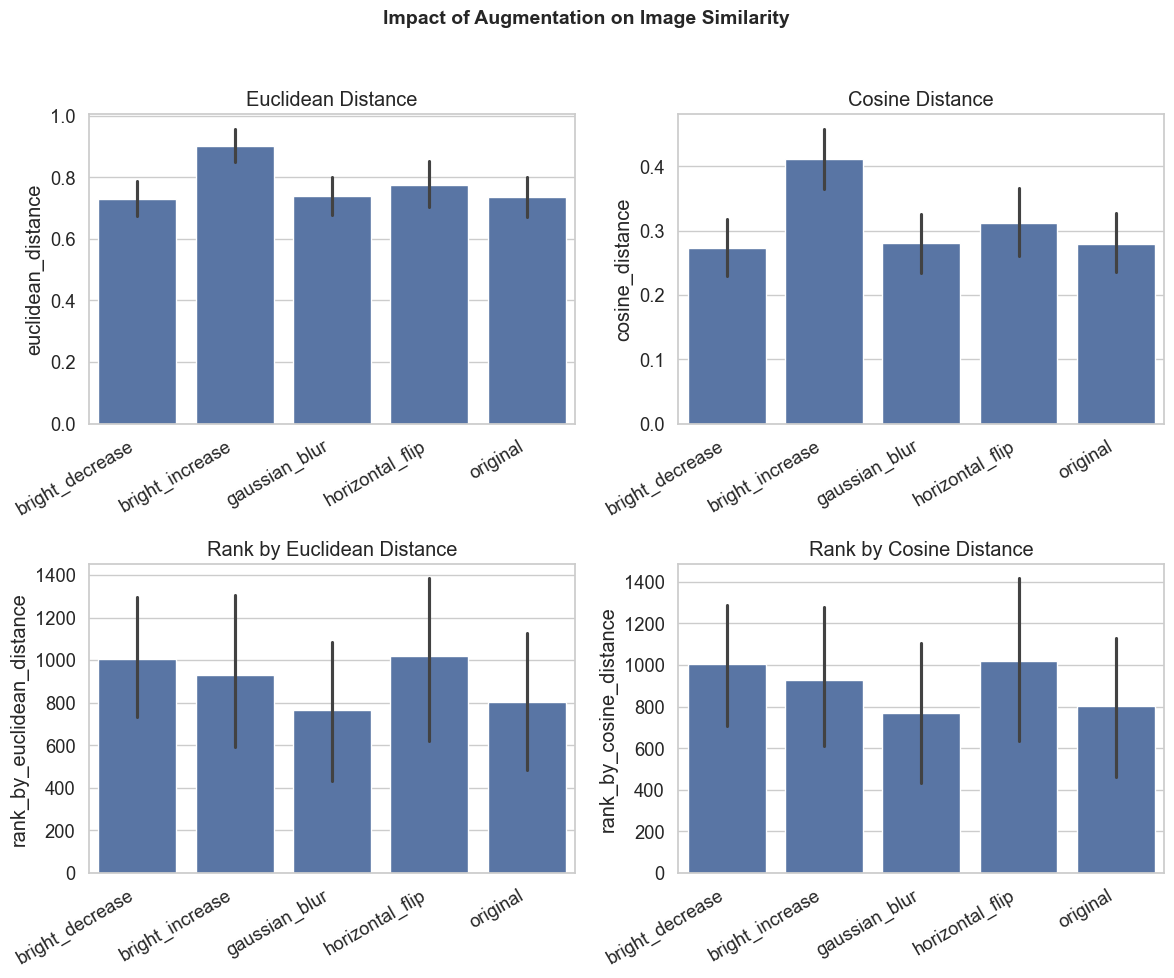

In [46]:
import warnings
warnings.filterwarnings('ignore') # supress warning in this case

# Visualize the distribution of distances and rankings
# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Impact of Augmentation on Image Similarity", fontsize=14, fontweight="bold")

# Plot settings
sns.set(style="whitegrid", font_scale=1.2)

# Euclidean Distance
sns.barplot(x="probe_image", y="euclidean_distance", data=rank, ax=axes[0, 0])
axes[0, 0].set_title("Euclidean Distance")
axes[0, 0].set_xticklabels([img[:-4] for img in rank["probe_image"]], rotation=30, ha="right")
axes[0, 0].xaxis.label.set_visible(False)

# Cosine Distance
sns.barplot(x="probe_image", y="cosine_distance", data=rank, ax=axes[0, 1])
axes[0, 1].set_title("Cosine Distance")
axes[0, 1].set_xticklabels([img[:-4] for img in rank["probe_image"]], rotation=30, ha="right")
axes[0, 1].xaxis.label.set_visible(False)

# Rank by Euclidean Distance
sns.barplot(x="probe_image", y="rank_by_euclidean_distance", data=rank, ax=axes[1, 0])
axes[1, 0].set_title("Rank by Euclidean Distance")
axes[1, 0].set_xticklabels([img[:-4] for img in rank["probe_image"]], rotation=30, ha="right")
axes[1, 0].xaxis.label.set_visible(False)

# Rank by Cosine Distance
sns.barplot(x="probe_image", y="rank_by_cosine_distance", data=rank, ax=axes[1, 1])
axes[1, 1].set_title("Rank by Cosine Distance")
axes[1, 1].set_xticklabels([img[:-4] for img in rank["probe_image"]], rotation=30, ha="right")
axes[1, 1].xaxis.label.set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations:

**Different Distance Metrics Show Similar Trends**
* Both Euclidean and cosine distances indicate similar ranking trends for different augmentations.

**Transformation Impact**
* **Brightness Increase Has the Largest Impact**: Among all augmentations, increasing brightness leads to the most significant changes in both Euclidean and cosine distances.
    * The model struggles more with brightened images than darkened images, as seen in the increased distance metrics.

* **Gaussian Blur Has the Least Impact**: Blurring causes the least deviation in image similarity, maintaining a close representation to the original.
* **Horizontal Flip and Bright Decrease Are Moderate**: These augmentations introduce some changes but not as drastically as brightness increase.

**Recommendations:**
- **Improve model robustness** with training on augmented images (especially brightness variations and image flips).
- **Use contrast normalization techniques** to mitigate brightness-related issues.
- **Ensure preprocessing accounts for flipped images** to avoid degradation in flipped cases.
